# Bank Fraud Detection by Ayan Kumar - 19BCE1828


In [1]:
# Necessary imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import pennylane as qml

from utils import *
import time
import math
from IPython.display import Image

## Data loading, processing and for more
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

## Visualization
import seaborn as sns
import matplotlib.pyplot as plt
# set seaborn style because it prettier
sns.set()

## Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

# Age: Categorized age
0: <= 18,
1: 19-25,
2: 26-35,
3: 36-45,
4: 46:55,
5: 56:65,
6: > 65
U: Unknown}

In [2]:
data = pd.read_csv("Data 1.csv")
data.head(5)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


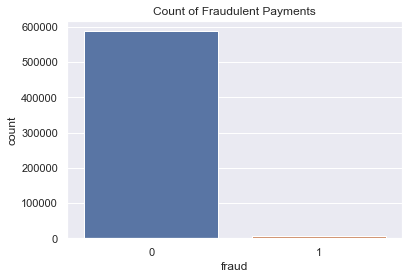

Number of normal examples:  587443
Number of fradulent examples:  7200


In [4]:
# Create two dataframes with fraud and non-fraud data 
df_fraud = data.loc[data.fraud == 1] 
df_non_fraud = data.loc[data.fraud == 0]

sns.countplot(x="fraud",data=data)
plt.title("Count of Fraudulent Payments")
plt.show()
print("Number of normal examples: ",df_non_fraud.fraud.count())
print("Number of fradulent examples: ",df_fraud.fraud.count())
#print(data.fraud.value_counts()) # does the same thing above

# The data is imbalanced as there are very less number of fraud samples

In [5]:
print("Mean feature values per category",data.groupby('category')['amount','fraud'].mean())

Mean feature values per category                               amount     fraud
category                                      
'es_barsandrestaurants'    43.461014  0.018829
'es_contents'              44.547571  0.000000
'es_fashion'               65.666642  0.017973
'es_food'                  37.070405  0.000000
'es_health'               135.621367  0.105126
'es_home'                 165.670846  0.152064
'es_hotelservices'        205.614249  0.314220
'es_hyper'                 45.970421  0.045917
'es_leisure'              288.911303  0.949900
'es_otherservices'        135.881524  0.250000
'es_sportsandtoys'        215.715280  0.495252
'es_tech'                 120.947937  0.066667
'es_transportation'        26.958187  0.000000
'es_travel'              2250.409190  0.793956
'es_wellnessandbeauty'     65.511221  0.047594


C:\Users\ENVY\AppData\Local\Temp/ipykernel_12252/1703450169.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print("Mean feature values per category",data.groupby('category')['amount','fraud'].mean())


In [6]:
# Create two dataframes with fraud and non-fraud data 
pd.concat([df_fraud.groupby('category')['amount'].mean(),df_non_fraud.groupby('category')['amount'].mean(),\
           data.groupby('category')['fraud'].mean()*100],keys=["Fraudulent","Non-Fraudulent","Percent(%)"],axis=1,\
          sort=False).sort_values(by=['Non-Fraudulent'])

,Fraudulent,Non-Fraudulent,Percent(%)
category,,,
'es_transportation',NaN,26.958187,0.000000
'es_food',NaN,37.070405,0.000000
'es_hyper',169.255429,40.037145,4.591669
'es_barsandrestaurants',164.092667,41.145997,1.882944
'es_contents',NaN,44.547571,0.000000
'es_wellnessandbeauty',229.422535,57.320219,4.759380
'es_fashion',247.008190,62.347674,1.797335
'es_leisure',300.286878,73.230400,94.989980
'es_otherservices',316.469605,75.685497,25.000000


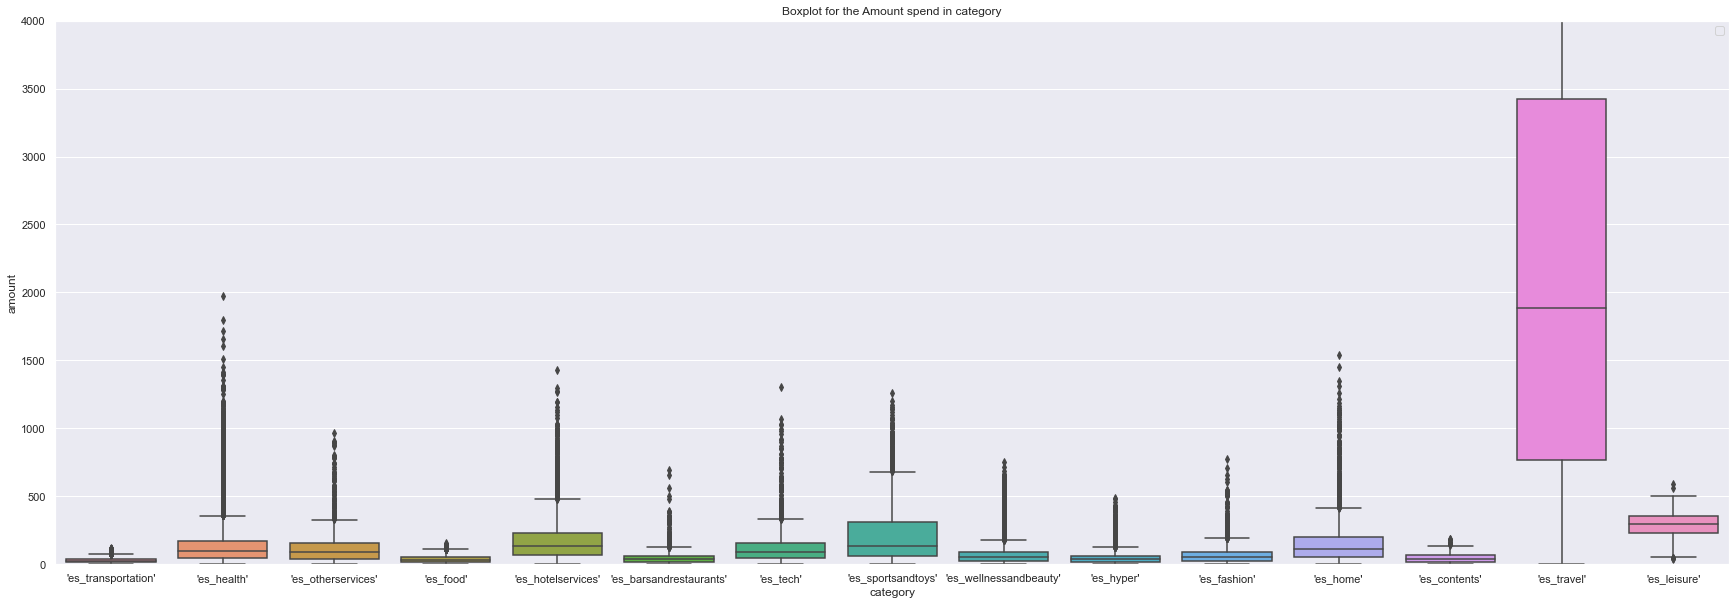

In [7]:
# Plot histograms of the amounts in fraud and non-fraud data 
plt.figure(figsize=(30,10))
sns.boxplot(x=data.category,y=data.amount)
plt.title("Boxplot for the Amount spend in category")
plt.ylim(0,4000)
plt.legend()
plt.show()

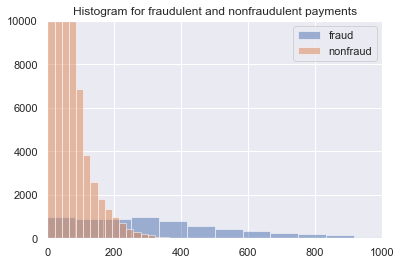

In [8]:
# Plot histograms of the amounts in fraud and non-fraud data 
plt.hist(df_fraud.amount, alpha=0.5, label='fraud',bins=100)
plt.hist(df_non_fraud.amount, alpha=0.5, label='nonfraud',bins=100)
plt.title("Histogram for fraudulent and nonfraudulent payments")
plt.ylim(0,10000)
plt.xlim(0,1000)
plt.legend()
plt.show()

In [9]:
print((data.groupby('age')['fraud'].mean()*100).reset_index().rename(columns={'age':'Age','fraud' : 'Fraud Percent'}).sort_values(by='Fraud Percent'))

   Age  Fraud Percent
7  'U'       0.594228
6  '6'       0.974826
5  '5'       1.095112
1  '1'       1.185254
3  '3'       1.192815
2  '2'       1.251401
4  '4'       1.293281
0  '0'       1.957586


In [10]:
print("Unique zipCodeOri values: ",data.zipcodeOri.nunique())
print("Unique zipMerchant values: ",data.zipMerchant.nunique())
# dropping zipcodeori and zipMerchant since they have only one unique value
data_reduced = data.drop(['zipcodeOri','zipMerchant'],axis=1)

Unique zipCodeOri values:  1
Unique zipMerchant values:  1


In [11]:
data_reduced.columns

Index(['step', 'customer', 'age', 'gender', 'merchant', 'category', 'amount',
       'fraud'],
      dtype='object')

In [100]:
# turning object columns type to categorical for easing the transformation process
col_categorical = data_reduced.select_dtypes(include= ['object']).columns
for col in col_categorical:
    data_reduced[col] = data_reduced[col].astype('category')
# categorical values ==> numeric values
data_reduced[col_categorical] = data_reduced[col_categorical].apply(lambda x: x.cat.codes)
data_reduced.tail(5)

,step,customer,age,gender,merchant,category,amount,fraud
594638,179,1639,3,1,18,12,20.53,0
594639,179,3369,4,1,18,12,50.73,0
594640,179,529,2,1,31,2,22.44,0
594641,179,1083,5,2,18,12,14.46,0
594642,179,3304,4,1,18,12,26.93,0


In [64]:
X = data_reduced.drop(['fraud'],axis=1)
y = data['fraud']
print(X.head(),"\n")
print(y.head())

   step  customer  age  gender  merchant  category  amount
0     0       210    4       2        30        12    4.55
1     0      2753    2       2        30        12   39.68
2     0      2285    4       1        18        12   26.89
3     0      1650    3       2        30        12   17.25
4     0      3585    5       2        30        12   35.72 

170217    0
717823    1
559516    0
759037    1
824544    1
Name: fraud, dtype: int64


# To balance the data ENN Smote is used that used Edited Nearest Neighbor to balance the number of samples in each class

In [14]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.combine import SMOTEENN 

In [15]:
from imblearn.over_sampling import SMOTE

xr, yr = SMOTE(k_neighbors=1).fit_resample(X, y)

counter = Counter(y)
print('Before' , counter)

smenn = SMOTEENN()

X_s, Y_s = smenn.fit_resample(xr,yr)

counter = Counter(Y_s)
print('After' , counter)

Before Counter({0: 587443, 1: 7200})
After Counter({1: 587442, 0: 579375})


# After Smote the size od dataset is too large and wont be suitable for QLSTM as we are using a simulator, hence we need to slice the dataset

In [207]:
data = pd.concat([X_s, Y_s], axis=1)
from sklearn.utils import shuffle
data = shuffle(data)
data = data[:5000]
data


,step,customer,age,gender,merchant,category,amount,fraud
1154480,141,1026,3,1,23,7,440.117555,1
693957,34,4069,3,1,15,10,14.670898,1
339539,112,3122,4,1,30,12,14.700000,0
24054,9,87,2,1,30,12,38.610000,0
140716,51,2082,2,1,18,12,30.050000,0
...,...,...,...,...,...,...,...,...
792764,9,3155,2,1,22,7,557.435215,1
190000,67,1510,3,1,18,12,11.850000,0
683252,83,2690,4,1,49,10,382.781966,1
1119217,131,2816,1,1,41,7,202.040428,1


In [232]:
z = data['fraud']
z[z ==1].count()

2558

In [233]:
df_train, df_test = train_test_split(data, test_size=0.2)


In [234]:
features = list(data.columns.difference(["Step", 'Amount']))
features

['age',
 'amount',
 'category',
 'customer',
 'fraud',
 'gender',
 'merchant',
 'step']

In [235]:
target = "fraud"

In [236]:
df_train

,step,customer,age,gender,merchant,category,amount,fraud
816631,62,969,4,1,49,10,542.655631,1
968818,70,2174,3,1,49,10,26.777763,1
154773,56,2930,2,2,30,12,34.170000,0
658811,38,483,2,2,40,13,3612.693079,1
366532,120,3347,4,1,30,12,55.870000,0
...,...,...,...,...,...,...,...,...
157944,57,1447,6,1,30,12,13.720000,0
846356,29,3885,1,2,3,8,362.021596,1
189105,67,2062,3,1,30,12,59.310000,0
892416,148,2309,4,1,34,4,633.120029,1


In [237]:
import torch
from torch.utils.data import Dataset

def __init__(self, dataframe, target, features, sequence_length=5):
   self.features = features
   self.target = target
   self.sequence_length = sequence_length
   self.y = torch.tensor(dataframe[target].values).float()
   self.X = torch.tensor(dataframe[features].values).float()         

In [238]:
import torch
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [239]:
torch.manual_seed(101)

batch_size = 1
sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 3, 8])
Target shape: torch.Size([1])


In [240]:
from torch import nn

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [241]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[self.target].values).float()
        self.X = torch.tensor(dataframe[self.features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [242]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [243]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

# Hyperparameters are choosen that would take time to train such as learning rate is taken 0.0001 because it will give more accuare result and the chaces of missing the minimum loss point in the descent also reduces

In [244]:
learning_rate = 0.0001
num_hidden_units = 16

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [245]:
classical_loss_train = []
classical_loss_test = []
print("Untrained test\n--------")
test_loss = test_model(test_loader, model, loss_function)
print()
classical_loss_test.append(test_loss)

for ix_epoch in range(10):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, model, loss_function)
    print()
    classical_loss_train.append(train_loss)
    classical_loss_test.append(test_loss)

Untrained test
--------
Test loss: 0.7141895583668356

Epoch 0
---------
Train loss: 0.3917407760507681
Test loss: 0.2675423662029835

Epoch 1
---------
Train loss: 0.23695919729476267
Test loss: 0.19900597613161874

Epoch 2
---------
Train loss: 0.15247962416455385
Test loss: 0.1006758773679187

Epoch 3
---------
Train loss: 0.0955899145831474
Test loss: 0.07928038580778238

Epoch 4
---------
Train loss: 0.08209155305131617
Test loss: 0.0691865459610412

Epoch 5
---------
Train loss: 0.07521272509605312
Test loss: 0.06669450480744013

Epoch 6
---------
Train loss: 0.0714909306062193
Test loss: 0.06371548697323068

Epoch 7
---------
Train loss: 0.0670513114243163
Test loss: 0.05743179754124266

Epoch 8
---------
Train loss: 0.0631488367399401
Test loss: 0.05764912187708239

Epoch 9
---------
Train loss: 0.06125364867516315
Test loss: 0.05135776556595422



In [246]:
classical_loss_train

[0.3917407760507681,
 0.23695919729476267,
 0.15247962416455385,
 0.0955899145831474,
 0.08209155305131617,
 0.07521272509605312,
 0.0714909306062193,
 0.0670513114243163,
 0.0631488367399401,
 0.06125364867516315]

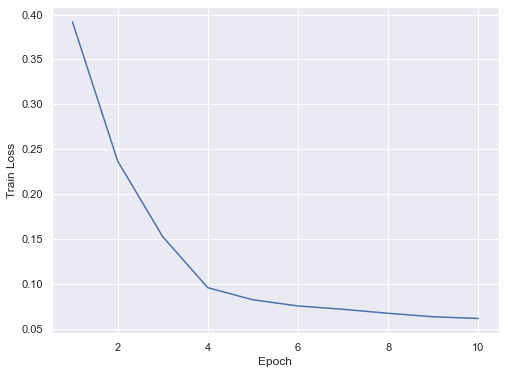

In [247]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), classical_loss_train)
plt.ylabel('Train Loss')
plt.xlabel('Epoch')
plt.show()

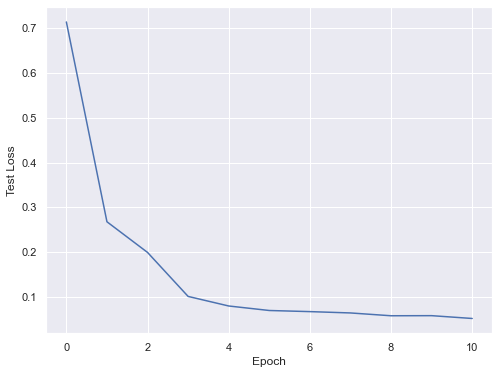

In [248]:
plt.figure(figsize=(8, 6))
plt.plot(range(11), classical_loss_test)
plt.ylabel('Test Loss')
plt.xlabel('Epoch')
plt.show()

In [249]:
def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

In [250]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c]

print(df_out)


        fraud  Model forecast
816631      1        1.014890
968818      1        0.205847
154773      0        0.009940
658811      1        0.956970
366532      0       -0.082636
...       ...             ...
348707      0        0.210242
719999      1        0.826328
74780       0        0.208683
999254      1        0.671682
983389      1        1.014839

[5000 rows x 2 columns]


In [251]:
j = 5000
dt = df_out[:j]

# The output is in decimal rather than 0 or 1 becuse the LSTM takes it as a regression problem instead of classiffication. This can even give a better result as it now giving a scale for the chances of a fraud

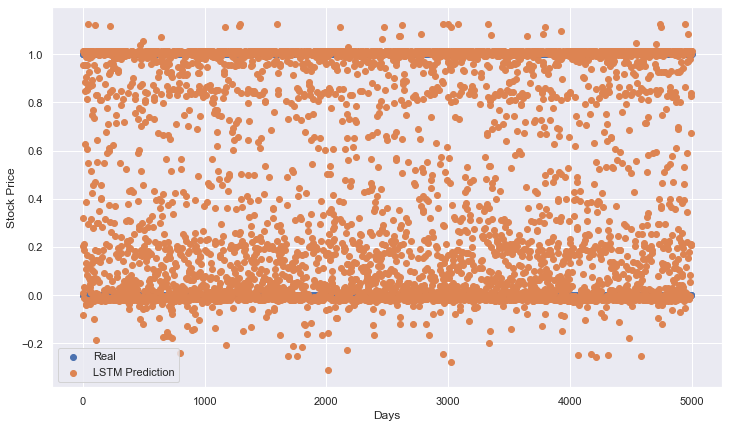

In [252]:
plt.figure(figsize=(12, 7))
plt.scatter(range(j), dt["fraud"], label = "Real")
plt.scatter(range(j), dt["Model forecast"], label = "LSTM Prediction")
plt.ylabel('Class')
plt.xlabel('Test case')
plt.legend()
plt.show()

In [253]:
class QLSTM(nn.Module):
    def __init__(self, 
                input_size, 
                hidden_size, 
                n_qubits=4,
                n_qlayers=1,
                n_vrotations=3,
                batch_first=True,
                return_sequences=False, 
                return_state=False,
                backend="default.qubit"):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.n_vrotations = n_vrotations
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state
        
        self.wires_forget = [f"wire_forget_{i}" for i in range(self.n_qubits)]
        self.wires_input = [f"wire_input_{i}" for i in range(self.n_qubits)]
        self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        self.wires_output = [f"wire_output_{i}" for i in range(self.n_qubits)]

        self.dev_forget = qml.device(self.backend, wires=self.wires_forget)
        self.dev_input = qml.device(self.backend, wires=self.wires_input)
        self.dev_update = qml.device(self.backend, wires=self.wires_update)
        self.dev_output = qml.device(self.backend, wires=self.wires_output)

        
        def ansatz(params, wires_type):
            # Entangling layer.
            for i in range(1,3): 
                for j in range(self.n_qubits):
                    if j + i < self.n_qubits:
                        qml.CNOT(wires=[wires_type[j], wires_type[j + i]])
                    else:
                        qml.CNOT(wires=[wires_type[j], wires_type[j + i - self.n_qubits]])

            # Variational layer.
            for i in range(self.n_qubits):
                qml.RX(params[0][i], wires=wires_type[i])
                qml.RY(params[1][i], wires=wires_type[i])
                qml.RZ(params[2][i], wires=wires_type[i])
                
        def VQC(features, weights, wires_type):
            # Preproccess input data to encode the initial state.
            #qml.templates.AngleEmbedding(features, wires=wires_type)
            ry_params = [torch.arctan(feature) for feature in features]
            rz_params = [torch.arctan(feature**2) for feature in features]
            for i in range(self.n_qubits):
                qml.Hadamard(wires=wires_type[i])
                qml.RY(ry_params[i], wires=wires_type[i])
                qml.RZ(ry_params[i], wires=wires_type[i])
        
            #Variational block.
            qml.layer(ansatz, self.n_qlayers, weights, wires_type = wires_type)

        def _circuit_forget(inputs, weights):
            VQC(inputs, weights, self.wires_forget)
            return [qml.expval(qml.PauliZ(wires=i)) for i in self.wires_forget]
        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch")

        def _circuit_input(inputs, weights):
            VQC(inputs, weights, self.wires_input)
            return [qml.expval(qml.PauliZ(wires=i)) for i in self.wires_input]
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch")

        def _circuit_update(inputs, weights):
            VQC(inputs, weights, self.wires_update)
            return [qml.expval(qml.PauliZ(wires=i)) for i in self.wires_update]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch")

        def _circuit_output(inputs, weights):
            VQC(inputs, weights, self.wires_output)
            return [qml.expval(qml.PauliZ(wires=i)) for i in self.wires_output]
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch")

        weight_shapes = {"weights": (self.n_qlayers, self.n_vrotations, self.n_qubits)}
        print(f"weight_shapes = (n_qlayers, n_vrotations, n_qubits) = ({self.n_qlayers}, {self.n_vrotations}, {self.n_qubits})")

        self.clayer_in = torch.nn.Linear(self.concat_size, self.n_qubits)
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)
        #self.clayer_out = [torch.nn.Linear(n_qubits, self.hidden_size) for _ in range(4)]

    def forward(self, x, init_states=None):
        '''
        x.shape is (batch_size, seq_length, feature_size)
        recurrent_activation -> sigmoid
        activation -> tanh
        '''
        if self.batch_first is True:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size, features_size = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)  # hidden state (output)
            c_t = torch.zeros(batch_size, self.hidden_size)  # cell state
        else:
            # for now we ignore the fact that in PyTorch you can stack multiple RNNs
            # so we take only the first elements of the init_states tuple init_states[0][0], init_states[1][0]
            h_t, c_t = init_states
            h_t = h_t[0]
            c_t = c_t[0]

        for t in range(seq_length):
            # get features from the t-th element in seq, for all entries in the batch
            x_t = x[:, t, :]
            
            # Concatenate input and hidden state
            v_t = torch.cat((h_t, x_t), dim=1)

            # match qubit dimension
            y_t = self.clayer_in(v_t)

            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](y_t)))  # forget block
            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](y_t)))  # input block
            g_t = torch.tanh(self.clayer_out(self.VQC['update'](y_t)))  # update block
            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](y_t))) # output block

            c_t = (f_t * c_t) + (i_t * g_t)
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

In [254]:
class QShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units, n_qubits=0, n_qlayers=1):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1
        
        self.lstm = QLSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            n_qubits = n_qubits,
            n_qlayers= n_qlayers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [ ]:
learning_rate = 0.01
num_hidden_units = 16

Qmodel = QShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units, n_qubits=4)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adagrad(Qmodel.parameters(), lr=learning_rate)

In [256]:
quantum_loss_train = []
quantum_loss_test = []
print("Untrained test\n--------")
start = time.time()
test_loss = test_model(test_loader, Qmodel, loss_function)
end = time.time()
print("Execution time", end - start)
quantum_loss_test.append(test_loss)

for ix_epoch in range(10):
    print(f"Epoch {ix_epoch}\n---------")
    start = time.time()
    train_loss = train_model(train_loader, Qmodel, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, Qmodel, loss_function)
    end = time.time()
    print("Execution time", end - start)
    quantum_loss_train.append(train_loss)
    quantum_loss_test.append(test_loss)

Untrained test
--------
Test loss: 0.7966344940960407
Execution time 127.8033082485199
Epoch 0
---------
Train loss: 0.25264336540840443
Test loss: 0.24920846196021013
Execution time 914.6447515487671
Epoch 1
---------
Train loss: 0.19351234006478432
Test loss: 0.11516386449011043
Execution time 912.9529159069061
Epoch 2
---------
Train loss: 0.11099094316482984
Test loss: 0.09195292054420685
Execution time 907.4865570068359
Epoch 3
---------
Train loss: 0.092950791313207
Test loss: 0.08179831813658497
Execution time 860.1751275062561
Epoch 4
---------
Train loss: 0.08687825665915028
Test loss: 0.09122913828756074
Execution time 895.7985031604767
Epoch 5
---------
Train loss: 0.08258540222782307
Test loss: 0.07287534592563984
Execution time 902.5966398715973
Epoch 6
---------
Train loss: 0.07802911918806593
Test loss: 0.0687531308077414
Execution time 904.9001877307892
Epoch 7
---------
Train loss: 0.0734267513374964
Test loss: 0.06292732407994163
Execution time 1130.2056920528412
Epoc

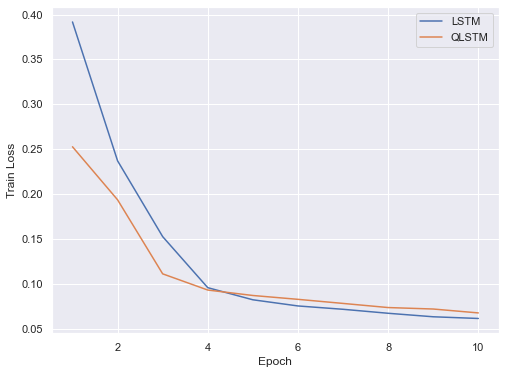

In [258]:
plt.figure(figsize=(8, 6))
plt.plot(range(1,11), classical_loss_train, label = "LSTM")
plt.plot(range(1,11), quantum_loss_train, label = "QLSTM")
plt.ylabel('Train Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Quantum LSTM will give even better results if the learning rate of QLSTM is reduced from 0.01 to 0.0001

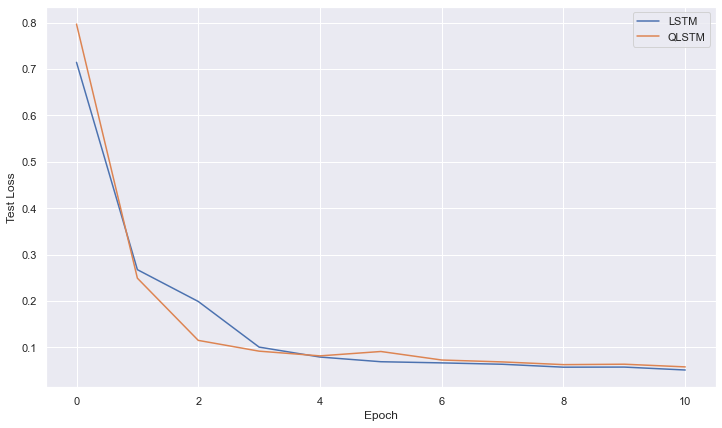

In [259]:
plt.figure(figsize=(12, 7))
plt.plot(range(11), classical_loss_test, label = "LSTM")
plt.plot(range(11), quantum_loss_test, label = "QLSTM")
plt.ylabel('Test Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [260]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col_Q = "Model forecast"
df_train[ystar_col_Q] = predict(train_eval_loader, Qmodel).numpy()
df_test[ystar_col_Q] = predict(test_loader, Qmodel).numpy()

df_out_Q = pd.concat((df_train, df_test))[[target, ystar_col_Q]]

for c in df_out_Q.columns:
    df_out_Q[c] = df_out_Q[c] 

print(df_out_Q)

        fraud  Model forecast
816631      1        0.998698
968818      1        0.228791
154773      0        0.083409
658811      1        0.869055
366532      0        0.177861
...       ...             ...
348707      0        0.174446
719999      1        0.905214
74780       0        0.175861
999254      1        0.905393
983389      1        0.988545

[5000 rows x 2 columns]


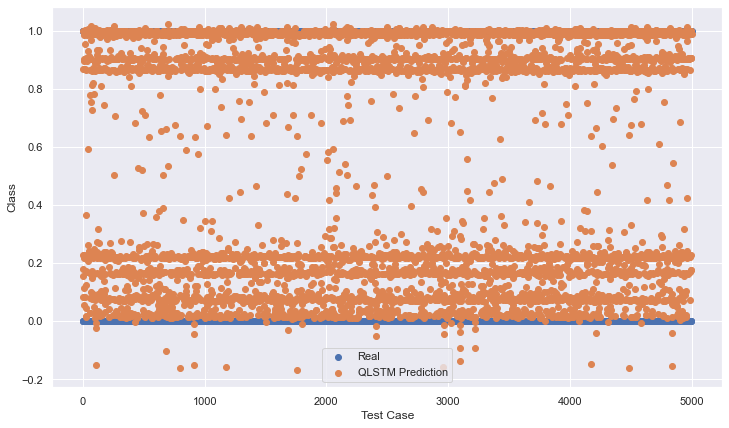

In [261]:
plt.figure(figsize=(12, 7))
plt.scatter(range(5000), df_out_Q["fraud"], label = "Real")
plt.scatter(range(5000), df_out_Q["Model forecast"], label = "QLSTM Prediction")
plt.ylabel('Class')
plt.xlabel('Test Case')
plt.legend()
plt.show()

# Root Mean Square Error of both the models

In [292]:
import math  
import sklearn.metrics  
qmse = sklearn.metrics.mean_squared_error(df_out["fraud"], df_out_Q["Model forecast"])  
qrmse = math.sqrt(qmse) 

cmse = sklearn.metrics.mean_squared_error(df_out["fraud"], df_out_Q["Model forecast"])  
crmse = math.sqrt(cmse) 
print("Root Mean Square Error of Classical LSTM = ",crmse)
print("Root Mean Square Error of Quantum LSTM = ",qrmse)

Root Mean Square Error of Classical LSTM =  0.25023310783942415
Root Mean Square Error of Quantum LSTM =  0.25023310783942415


In [286]:
Qerror = pd.DataFrame(abs(df_out_Q['fraud'] - df_out_Q['Model forecast']),columns=['qerror'])
Cerror = pd.DataFrame(abs(df_out['fraud'] - df_out['Model forecast']),columns=['cerror'])
Errors = pd.concat([Qerror, Cerror])
Errors.reindex()
Errors.sort_values('qerror')
Errors.sort_values('cerror')
Errors
Errors.head

<bound method NDFrame.head of           qerror    cerror
816631  0.001302       NaN
968818  0.771209       NaN
154773  0.083409       NaN
658811  0.130945       NaN
366532  0.177861       NaN
...          ...       ...
348707       NaN  0.210242
719999       NaN  0.173672
74780        NaN  0.208683
999254       NaN  0.328318
983389       NaN  0.014839

[10000 rows x 2 columns]>

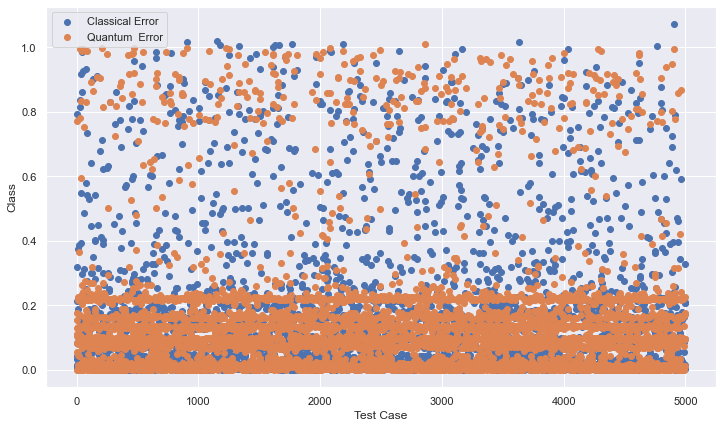

In [265]:
plt.figure(figsize=(12, 7))
plt.scatter(range(5000), Cerror, label = "Classical Error")
plt.scatter(range(5000), Qerror, label = "Quantum  Error")
plt.ylabel('Class')
plt.xlabel('Test Case')
plt.legend()
plt.show()